In [1]:
import utility as ut
import numpy as np
import matplotlib.pyplot as plt
from numba import jit
import pandas as pd

In [2]:
def get_quality_metrics(simulation_result, setpoints):
    NUM_STEPS = len(simulation_result["time"])
    time = [simulation_result["time"][i] for i in range(NUM_STEPS)]
    trolley_position = [
        simulation_result["trolley_position"][i] for i in range(NUM_STEPS)
    ]
    cable_length = [simulation_result["cable_length"][i] for i in range(NUM_STEPS)]
    sway_angle = [simulation_result["sway_angle"][i] for i in range(NUM_STEPS)]

    # Calculate rise time, settling time, overshoot, and RMSE for x
    rise_10_index_x, rise_90_index_x = ut.get_rise_index(trolley_position, setpoints["x"])
    rise_time_x = time[rise_90_index_x] - time[rise_10_index_x]
    settling_index_x = ut.get_settling_index(
        trolley_position, setpoints["x"], threshold=0.05
    )
    settling_time_x = time[settling_index_x] - time[0]
    overshoot_index_x = ut.get_overshoot_index(trolley_position, setpoints["x"])
    overshoot_x = (
        trolley_position[overshoot_index_x] - setpoints["x"]
        if overshoot_index_x < NUM_STEPS
        else 0
    )
    RMSE_x = ut.get_RMSE_settle(trolley_position[settling_index_x:], setpoints["x"])

    # Calculate rise time, settling time, overshoot, and RMSE for l
    rise_10_index_l, rise_90_index_l = ut.get_rise_index(cable_length, setpoints["l"])
    rise_time_l = time[rise_90_index_l] - time[rise_10_index_l]
    settling_index_l = ut.get_settling_index(cable_length, setpoints["l"], threshold=0.05)
    settling_time_l = time[settling_index_l] - time[0]
    overshoot_index_l = ut.get_overshoot_index(cable_length, setpoints["l"])
    overshoot_l = (
        cable_length[overshoot_index_l] - setpoints["l"]
        if overshoot_index_l < NUM_STEPS
        else 0
    )
    RMSE_l = ut.get_RMSE_settle(cable_length[settling_index_l:], setpoints["l"])

    # Calculate settling time and RMSE for theta
    settling_index_theta = ut.get_settling_index(
        sway_angle, 0, threshold=0.02
    )  # threshold = 0.01 rad = 0.57 deg
    settling_time_theta = time[settling_index_theta] - time[0]
    RMSE_theta = ut.get_RMSE_settle(sway_angle[settling_index_theta:], 0)
    max_amplitude_theta = np.max(np.abs(sway_angle))

    return {
        "rise_time_x": rise_time_x,
        "settling_time_x": settling_time_x,
        "overshoot_x": overshoot_x,
        "RMSE_x": RMSE_x,
        "rise_time_l": rise_time_l,
        "settling_time_l": settling_time_l,
        "overshoot_l": overshoot_l,
        "RMSE_l": RMSE_l,
        "settling_time_theta": settling_time_theta,
        "RMSE_theta": np.rad2deg(RMSE_theta),
        "max_amplitude_theta": np.rad2deg(max_amplitude_theta),
    }

In [3]:
RESULTS_PATH = "compare_light_and_dark/"
# Load data
LIGHT_DIRECTORY = "light_mode_gantry_crane/"
light_datasets = ut.load_excel_data(RESULTS_PATH + LIGHT_DIRECTORY)

# Load data
DARK_DIRECTORY = "dark_mode_gantry_crane/"
dark_datasets = ut.load_excel_data(RESULTS_PATH + DARK_DIRECTORY)

In [4]:
light_datasets[0]["timestamp"] = light_datasets[0]["timestamp"] - light_datasets[0]["timestamp"][0]
dark_datasets[0]["timestamp"] = dark_datasets[0]["timestamp"] - dark_datasets[0]["timestamp"][0]

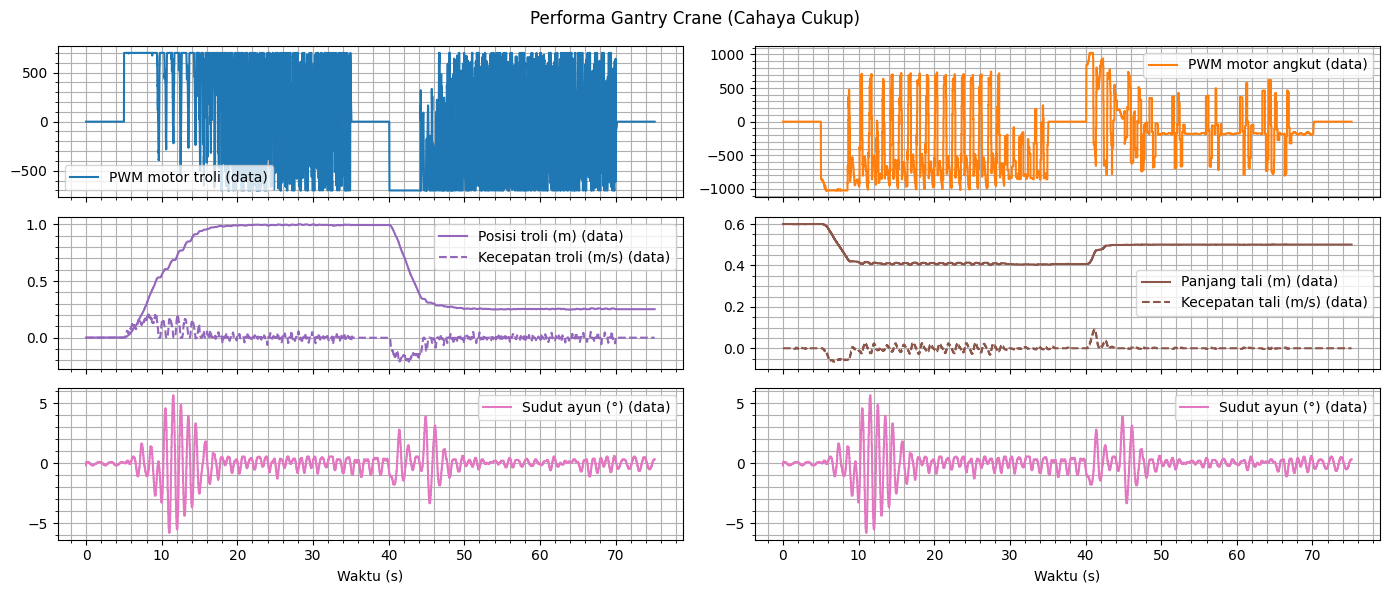

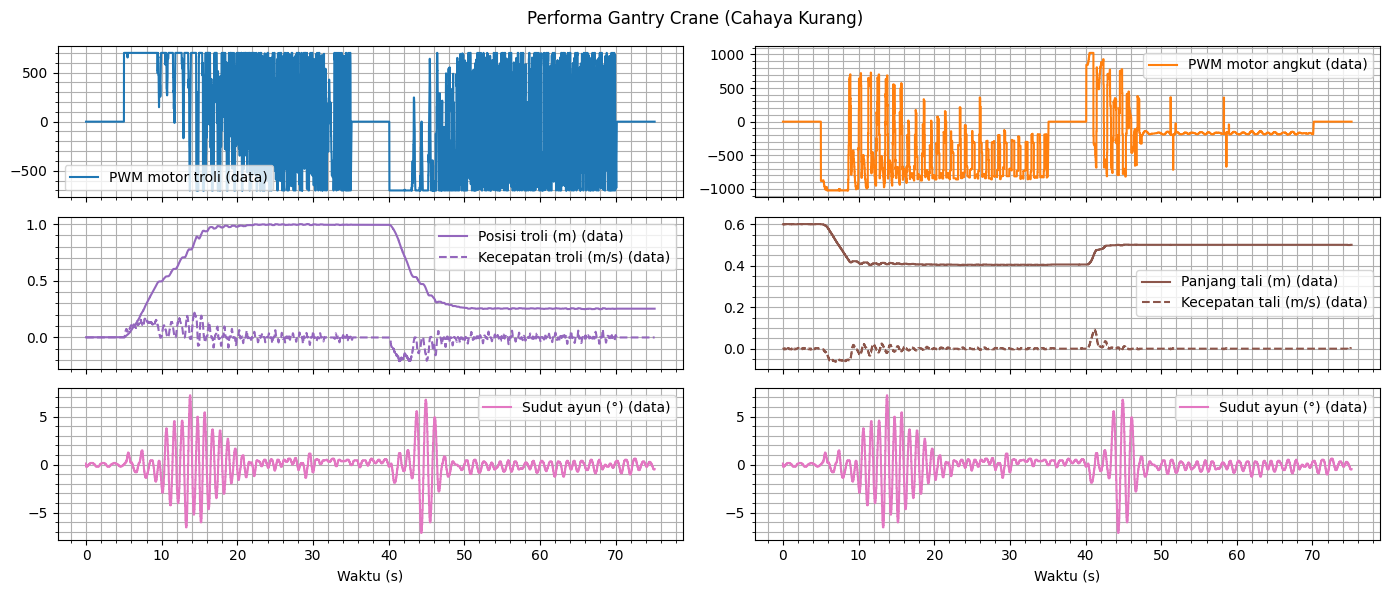

In [5]:
for index, dataset in enumerate(light_datasets):
    # Create a figure and a set of subplots
    figure, ax = plt.subplots(3, 2, figsize=(14, 6), sharex=True)
    title = "Performa Gantry Crane (Cahaya Cukup)"
    plt.rcParams.update({"font.size": 10})
    figure.suptitle(title, fontsize=12)
    ut.add_to_subplot(ax[0, 0], dataset["timestamp"], dataset["pwm_trolley_motor"], ylabel="PWM motor troli (data)", color=plt.get_cmap("tab20")(0))
    ut.add_to_subplot(ax[0, 1], dataset["timestamp"], dataset["pwm_hoist_motor"], ylabel="PWM motor angkut (data)", color=plt.get_cmap("tab20")(2))
    ut.add_to_subplot(ax[1, 0], dataset["timestamp"], dataset["trolley_position"], ylabel="Posisi troli (m) (data)", color=plt.get_cmap("tab20")(8))
    ut.add_to_subplot(ax[1, 0], dataset["timestamp"], dataset["trolley_position_first_derivative"], ylabel="Kecepatan troli (m/s) (data)", color=plt.get_cmap("tab20")(8), linestyle="--")
    ut.add_to_subplot(ax[1, 1], dataset["timestamp"], dataset["cable_length"], ylabel="Panjang tali (m) (data)", color=plt.get_cmap("tab20")(10))
    ut.add_to_subplot(ax[1, 1], dataset["timestamp"], dataset["cable_length_first_derivative"], ylabel="Kecepatan tali (m/s) (data)", color=plt.get_cmap("tab20")(10), linestyle="--")
    ut.add_to_subplot(ax[2, 0], dataset["timestamp"], np.rad2deg(dataset["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (data)", color=plt.get_cmap("tab20")(12))
    ut.add_to_subplot(ax[2, 1], dataset["timestamp"], np.rad2deg(dataset["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (data)", color=plt.get_cmap("tab20")(12))
    plt.tight_layout()
    ax[1, 0].grid(which="both")
    ax[1, 1].grid(which="both")
    # Save the figure as SVG
    # plt.savefig(DIRECTORY + "figure/"+ title +".svg")
    plt.show()


for index, dataset in enumerate(dark_datasets):
    # Create a figure and a set of subplots
    figure, ax = plt.subplots(3, 2, figsize=(14, 6), sharex=True)
    title = "Performa Gantry Crane (Cahaya Kurang)"
    plt.rcParams.update({"font.size": 10})
    figure.suptitle(title, fontsize=12)
    ut.add_to_subplot(ax[0, 0], dataset["timestamp"], dataset["pwm_trolley_motor"], ylabel="PWM motor troli (data)", color=plt.get_cmap("tab20")(0))
    ut.add_to_subplot(ax[0, 1], dataset["timestamp"], dataset["pwm_hoist_motor"], ylabel="PWM motor angkut (data)", color=plt.get_cmap("tab20")(2))
    ut.add_to_subplot(ax[1, 0], dataset["timestamp"], dataset["trolley_position"], ylabel="Posisi troli (m) (data)", color=plt.get_cmap("tab20")(8))
    ut.add_to_subplot(ax[1, 0], dataset["timestamp"], dataset["trolley_position_first_derivative"], ylabel="Kecepatan troli (m/s) (data)", color=plt.get_cmap("tab20")(8), linestyle="--")
    ut.add_to_subplot(ax[1, 1], dataset["timestamp"], dataset["cable_length"], ylabel="Panjang tali (m) (data)", color=plt.get_cmap("tab20")(10))
    ut.add_to_subplot(ax[1, 1], dataset["timestamp"], dataset["cable_length_first_derivative"], ylabel="Kecepatan tali (m/s) (data)", color=plt.get_cmap("tab20")(10), linestyle="--")
    ut.add_to_subplot(ax[2, 0], dataset["timestamp"], np.rad2deg(dataset["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (data)", color=plt.get_cmap("tab20")(12))
    ut.add_to_subplot(ax[2, 1], dataset["timestamp"], np.rad2deg(dataset["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (data)", color=plt.get_cmap("tab20")(12))
    plt.tight_layout()
    ax[1, 0].grid(which="both")
    ax[1, 1].grid(which="both")
    # Save the figure as SVG
    # plt.savefig(DIRECTORY + "figure/"+ title +".svg")
    plt.show()

In [6]:
light_start_first_section_index = len(light_datasets[0]["pwm_trolley_motor"]) - 1
for i in range (len(light_datasets[0]["pwm_trolley_motor"])):
    if light_datasets[0]["pwm_trolley_motor"][i] > 0:
        light_start_first_section_index = i
        break

light_start_second_section_index = len(light_datasets[0]["pwm_trolley_motor"]) - 1
for i in range (light_start_first_section_index, len(light_datasets[0]["pwm_trolley_motor"])):
    if (light_datasets[0]["pwm_trolley_motor"][i] != 0) and light_datasets[0]["timestamp"][i] > 36:
        light_start_second_section_index = i
        break

light_first_section = {
    "time": np.array(light_datasets[0]["timestamp"][light_start_first_section_index:(light_start_second_section_index - 1)].tolist()),
    "trolley_position": np.array(light_datasets[0]["trolley_position"][light_start_first_section_index:(light_start_second_section_index - 1)].tolist()),
    "cable_length": np.array(light_datasets[0]["cable_length"][light_start_first_section_index:(light_start_second_section_index - 1)].tolist()),
    "sway_angle": np.array(light_datasets[0]["sway_angle"][light_start_first_section_index:(light_start_second_section_index - 1)].tolist()),
    "trolley_speed": np.array(light_datasets[0]["trolley_position_first_derivative"][light_start_first_section_index:(light_start_second_section_index - 1)].tolist()),
    "cable_speed": np.array(light_datasets[0]["cable_length_first_derivative"][light_start_first_section_index:(light_start_second_section_index - 1)].tolist()),
    "trolley_motor_pwm": np.array(light_datasets[0]["pwm_trolley_motor"][light_start_first_section_index:(light_start_second_section_index - 1)].tolist()),
    "hoist_motor_pwm": np.array(light_datasets[0]["pwm_hoist_motor"][light_start_first_section_index:(light_start_second_section_index - 1)].tolist()),
    "trolley_motor_voltage": np.array(light_datasets[0]["trolley_motor_voltage"][light_start_first_section_index:(light_start_second_section_index - 1)].tolist()),
    "hoist_motor_voltage": np.array(light_datasets[0]["hoist_motor_voltage"][light_start_first_section_index:(light_start_second_section_index - 1)].tolist()),
}

light_second_section = {
    "time": np.array(light_datasets[0]["timestamp"][(light_start_second_section_index - 1):].tolist()),
    "trolley_position": np.array(light_datasets[0]["trolley_position"][(light_start_second_section_index - 1):].tolist()),
    "cable_length": np.array(light_datasets[0]["cable_length"][(light_start_second_section_index - 1):].tolist()),
    "sway_angle": np.array(light_datasets[0]["sway_angle"][(light_start_second_section_index - 1):].tolist()),
    "trolley_speed": np.array(light_datasets[0]["trolley_position_first_derivative"][(light_start_second_section_index - 1):].tolist()),
    "cable_speed": np.array(light_datasets[0]["cable_length_first_derivative"][(light_start_second_section_index - 1):].tolist()),
    "trolley_motor_pwm": np.array(light_datasets[0]["pwm_trolley_motor"][(light_start_second_section_index - 1):].tolist()),
    "hoist_motor_pwm": np.array(light_datasets[0]["pwm_hoist_motor"][(light_start_second_section_index - 1):].tolist()),
    "trolley_motor_voltage": np.array(light_datasets[0]["trolley_motor_voltage"][(light_start_second_section_index - 1):].tolist()),
    "hoist_motor_voltage": np.array(light_datasets[0]["hoist_motor_voltage"][(light_start_second_section_index - 1):].tolist()),
    }

In [7]:
dark_start_first_section_index = len(dark_datasets[0]["pwm_trolley_motor"]) - 1
for i in range (len(dark_datasets[0]["pwm_trolley_motor"])):
    if dark_datasets[0]["pwm_trolley_motor"][i] > 0:
        dark_start_first_section_index = i
        break

dark_start_second_section_index = len(dark_datasets[0]["pwm_trolley_motor"]) - 1
for i in range (dark_start_first_section_index, len(dark_datasets[0]["pwm_trolley_motor"])):
    if (dark_datasets[0]["pwm_trolley_motor"][i] != 0) and dark_datasets[0]["timestamp"][i] > 36:
        dark_start_second_section_index = i
        break

dark_first_section = {
    "time": np.array(dark_datasets[0]["timestamp"][dark_start_first_section_index:(dark_start_second_section_index - 1)].tolist()),
    "trolley_position": np.array(dark_datasets[0]["trolley_position"][dark_start_first_section_index:(dark_start_second_section_index - 1)].tolist()),
    "cable_length": np.array(dark_datasets[0]["cable_length"][dark_start_first_section_index:(dark_start_second_section_index - 1)].tolist()),
    "sway_angle": np.array(dark_datasets[0]["sway_angle"][dark_start_first_section_index:(dark_start_second_section_index - 1)].tolist()),
    "trolley_speed": np.array(dark_datasets[0]["trolley_position_first_derivative"][dark_start_first_section_index:(dark_start_second_section_index - 1)].tolist()),
    "cable_speed": np.array(dark_datasets[0]["cable_length_first_derivative"][dark_start_first_section_index:(dark_start_second_section_index - 1)].tolist()),
    "trolley_motor_pwm": np.array(dark_datasets[0]["pwm_trolley_motor"][dark_start_first_section_index:(dark_start_second_section_index - 1)].tolist()),
    "hoist_motor_pwm": np.array(dark_datasets[0]["pwm_hoist_motor"][dark_start_first_section_index:(dark_start_second_section_index - 1)].tolist()),
    "trolley_motor_voltage": np.array(dark_datasets[0]["trolley_motor_voltage"][dark_start_first_section_index:(dark_start_second_section_index - 1)].tolist()),
    "hoist_motor_voltage": np.array(dark_datasets[0]["hoist_motor_voltage"][dark_start_first_section_index:(dark_start_second_section_index - 1)].tolist()),
}

dark_second_section = {
    "time": np.array(dark_datasets[0]["timestamp"][(dark_start_second_section_index - 1):].tolist()),
    "trolley_position": np.array(dark_datasets[0]["trolley_position"][(dark_start_second_section_index - 1):].tolist()),
    "cable_length": np.array(dark_datasets[0]["cable_length"][(dark_start_second_section_index - 1):].tolist()),
    "sway_angle": np.array(dark_datasets[0]["sway_angle"][(dark_start_second_section_index - 1):].tolist()),
    "trolley_speed": np.array(dark_datasets[0]["trolley_position_first_derivative"][(dark_start_second_section_index - 1):].tolist()),
    "cable_speed": np.array(dark_datasets[0]["cable_length_first_derivative"][(dark_start_second_section_index - 1):].tolist()),
    "trolley_motor_pwm": np.array(dark_datasets[0]["pwm_trolley_motor"][(dark_start_second_section_index - 1):].tolist()),
    "hoist_motor_pwm": np.array(dark_datasets[0]["pwm_hoist_motor"][(dark_start_second_section_index - 1):].tolist()),
    "trolley_motor_voltage": np.array(dark_datasets[0]["trolley_motor_voltage"][(dark_start_second_section_index - 1):].tolist()),
    "hoist_motor_voltage": np.array(dark_datasets[0]["hoist_motor_voltage"][(dark_start_second_section_index - 1):].tolist()),
}

In [8]:
light_dataset = {
    'first_section' : light_first_section,
    'second_section' : light_second_section
}
dark_dataset = {
    'first_section' : dark_first_section,
    'second_section' : dark_second_section
}
setpoint = [[1.0, 0.4], [0.25, 0.5]]
metrics = ['rise_time_x', 'settling_time_x', 'overshoot_x', 'RMSE_x', 'rise_time_l', 'settling_time_l', 'overshoot_l', 'RMSE_l', 'settling_time_theta', 'RMSE_theta', 'max_amplitude_theta']

In [9]:
print(light_dataset['first_section'])

{'time': array([ 5.0210886 ,  5.02682352,  5.02737331, ..., 40.07375216,
       40.08359861, 40.08417177]), 'trolley_position': array([0.00117, 0.00117, 0.00117, ..., 0.99439, 0.99439, 0.99439]), 'cable_length': array([0.6  , 0.6  , 0.6  , ..., 0.407, 0.407, 0.407]), 'sway_angle': array([ 0.001,  0.001,  0.001, ..., -0.012, -0.012, -0.012]), 'trolley_speed': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       6.11490025e-17, 6.11490025e-17, 6.11490025e-17]), 'cable_speed': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
       1.38777878e-17, 1.38777878e-17, 1.38777878e-17]), 'trolley_motor_pwm': array([700., 700., 700., ...,   0.,   0.,   0.]), 'hoist_motor_pwm': array([-859.22178927, -859.22178927, -859.22178927, ...,    0.        ,
          0.        ,    0.        ]), 'trolley_motor_voltage': array([nan, nan, nan, ..., nan, nan, nan]), 'hoist_motor_voltage': array([nan, nan, nan, ..., nan, nan, nan])}


In [10]:
# Simulate the gantry crane system using the best parameters
for section_index, (light_section, dark_section) in enumerate(zip(light_dataset, dark_dataset)):
    setpoints = {
        "x": setpoint[section_index][0],
        "l": setpoint[section_index][1],
    }

    print(setpoints)

    light_dataset[light_section]["time"] = light_dataset[light_section]["time"] - light_dataset[light_section]["time"][0]
    dark_dataset[dark_section]["time"] = dark_dataset[dark_section]["time"] - dark_dataset[dark_section]["time"][0]

    light_mode_quality_metrics = ut.get_quality_metrics(light_dataset[light_section], setpoints)
    dark_mode_quality_metrics = ut.get_quality_metrics(dark_dataset[dark_section], setpoints)

    variation = {
        'Metrik': metrics,
        'Light': list(light_mode_quality_metrics.values()),
        'Dark': list(dark_mode_quality_metrics.values())
    }

    df = pd.DataFrame(variation)

    with pd.ExcelWriter(RESULTS_PATH + f"light_and_dark_metrics.xlsx", engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
        df.to_excel(writer, sheet_name=f'Section {section_index+1}', index=False)

    # Create a figure and a set of subplots
    figure, ax = plt.subplots(3, 2, figsize=(12, 6), sharex=True)
    plt.rcParams.update({"font.size": 10})
    figure.suptitle(f"Variasi {section_index+1}", fontsize=12)
    ut.add_to_subplot(ax[0, 0], dark_dataset[dark_section]["time"], dark_dataset[dark_section]["trolley_motor_pwm"], ylabel="PWM motor troli (gelap)", color=plt.get_cmap("tab20")(0))
    ut.add_to_subplot(ax[0, 1], dark_dataset[dark_section]["time"], dark_dataset[dark_section]["hoist_motor_pwm"], ylabel="PWM motor angkut (gelap)", color=plt.get_cmap("tab20")(2))
    ut.add_to_subplot(ax[1, 0], dark_dataset[dark_section]["time"], dark_dataset[dark_section]["trolley_position"], ylabel="Posisi troli (m) (gelap)", color=plt.get_cmap("tab20")(8))
    ut.add_to_subplot(ax[1, 1], dark_dataset[dark_section]["time"], dark_dataset[dark_section]["cable_length"], ylabel="Panjang tali (m) (gelap)", color=plt.get_cmap("tab20")(10))
    ut.add_to_subplot(ax[2, 0], dark_dataset[dark_section]["time"], np.rad2deg(dark_dataset[dark_section]["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (gelap)", color=plt.get_cmap("tab20")(12))
    ut.add_to_subplot(ax[2, 1], dark_dataset[dark_section]["time"], np.rad2deg(dark_dataset[dark_section]["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (gelap)", color=plt.get_cmap("tab20")(12))

    ut.add_to_subplot(ax[0, 0], light_dataset[light_section]["time"], light_dataset[light_section]["trolley_motor_pwm"], ylabel="PWM motor troli (terang)", color=plt.get_cmap("tab20")(1))
    ut.add_to_subplot(ax[0, 1], light_dataset[light_section]["time"], light_dataset[light_section]["hoist_motor_pwm"], ylabel="PWM motor angkut (terang)", color=plt.get_cmap("tab20")(3))
    ut.add_to_subplot(ax[1, 0], light_dataset[light_section]["time"], light_dataset[light_section]["trolley_position"], ylabel="Posisi troli (m) (terang)", color=plt.get_cmap("tab20")(9))
    ut.add_to_subplot(ax[1, 1], light_dataset[light_section]["time"], light_dataset[light_section]["cable_length"], ylabel="Panjang tali (m) (terang)", color=plt.get_cmap("tab20")(11))
    ut.add_to_subplot(ax[2, 0], light_dataset[light_section]["time"], np.rad2deg(light_dataset[light_section]["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (terang)", color=plt.get_cmap("tab20")(13))
    ut.add_to_subplot(ax[2, 1], light_dataset[light_section]["time"], np.rad2deg(light_dataset[light_section]["sway_angle"]), "Waktu (s)", "Sudut ayun (°) (terang)", color=plt.get_cmap("tab20")(13))

    plt.tight_layout()

    # Save the figure as SVG
    plt.savefig(RESULTS_PATH + f"figure/section_{section_index+1}.svg")
    plt.show()

{'x': 1.0, 'l': 0.4}


AttributeError: module 'utility' has no attribute 'get_quality_metrics'